In [50]:
import matplotlib.pyplot as plt
import numba
import numpy as np
from time import time
import pandas as pd
import seaborn as sns
from random import randint
import random
from typing import Iterable
import math
import os
import sys

sys.path.append(os.path.abspath(".."))
import tumba

sns.set_style("darkgrid")


def benchmark(func, list_of_args: list[tuple | int], x_values: Iterable[int], log_scalex=False):
    numba_func = numba.njit(fastmath=True)(func)
    tumba_func = tumba.compile(func)

    # Calling numba function for the first time so that it compiles
    arg0 = list_of_args[0]
    if not isinstance(arg0, tuple):
        arg0 = (arg0,)
    numba_func(*arg0)
    
    benchmark_data = pd.DataFrame(columns=["x", "time", "func_type"])
    for args, x in zip(list_of_args, x_values):
        if not isinstance(args, tuple):
            args = (args,)
        s = time()
        func(*args)
        t_native = time() - s

        s = time()
        numba_func(*args)
        t_numba = time() - s

        s = time()
        tumba_func(*args)
        t_tumba = time() - s

        benchmark_data.loc[len(benchmark_data)] = [x, t_native, "native"]
        benchmark_data.loc[len(benchmark_data)] = [x, t_numba, "numba"]
        benchmark_data.loc[len(benchmark_data)] = [x, t_tumba, "tumba"]

    last_time_native = benchmark_data[benchmark_data.func_type == "native"].iloc[-1].time
    last_time_numba = benchmark_data[benchmark_data.func_type == "numba"].iloc[-1].time
    last_time_tumba = benchmark_data[benchmark_data.func_type == "tumba"].iloc[-1].time
    ratio_native_tumba = last_time_native / last_time_tumba
    ratio_tumba_numba = last_time_tumba / last_time_numba
    
    g = sns.relplot(
        data=benchmark_data,
        x="x",
        y="time",
        hue="func_type",
        kind="scatter",
        s=10
    )

    # Adding text
    ax = g.axes[0, 0]
    ax.text(0.01, 0.9, """tumba быстрее python в {:.2f} раз
numba быстрее tumba в {:.2f} раз""".format(ratio_native_tumba, ratio_tumba_numba), 
            horizontalalignment='left',
           transform=ax.transAxes)
    
    if log_scalex:
        g.set(xscale="log")
    plt.show()

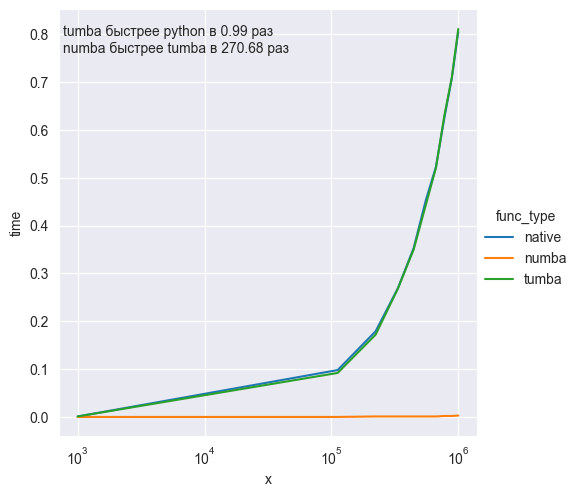

In [27]:
def avg1(n: int) -> float:
    x = 0
    i = 0
    while i < n:
        x = x + i
        i = i + 1
    return i / n

Ns = np.linspace(1000, 10**6, num=10, dtype=int)
benchmark(random_sum, Ns, Ns, log_scalex=True)

C:\Users\Gleb\AppData\Local\Temp\ipykernel_2152\4036942558.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  ratio_tumba_numba = last_time_tumba / last_time_numba


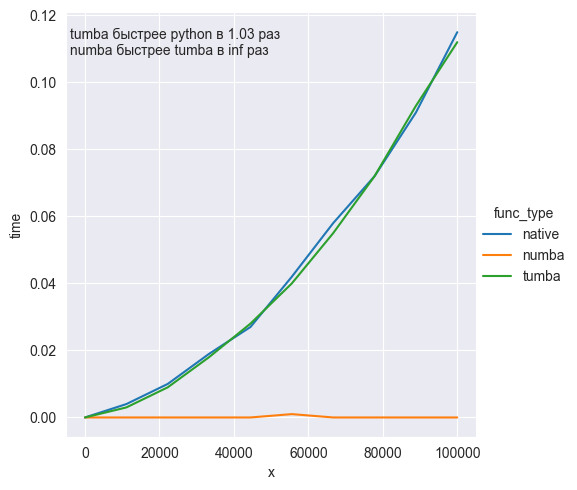

In [29]:
def fib_iterative(N: int) -> int:
    a = 0
    b = 1
    while N != 0:
        tmp = b
        b = a + b
        a = tmp
        N = N - 1
    return a

Ns = np.linspace(0, 100000, num=10, dtype=int)
benchmark(fib_iterative, Ns, Ns)

C:\Users\Gleb\AppData\Local\Temp\ipykernel_2152\1718076634.py:53: RuntimeWarning: invalid value encountered in scalar divide
  ratio_native_tumba = last_time_native / last_time_tumba
C:\Users\Gleb\AppData\Local\Temp\ipykernel_2152\1718076634.py:54: RuntimeWarning: invalid value encountered in scalar divide
  ratio_tumba_numba = last_time_tumba / last_time_numba


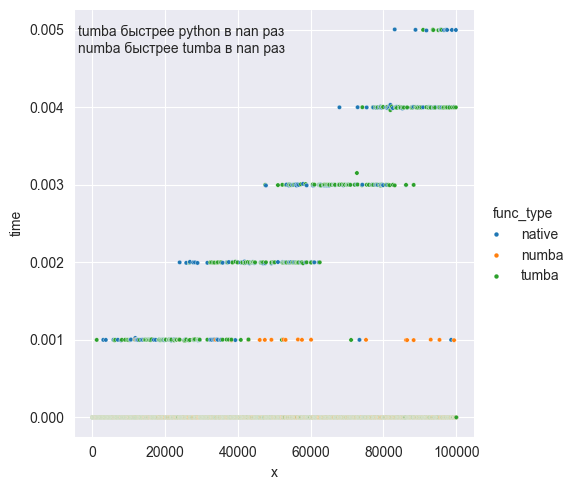

In [51]:
def is_prime(N: int) -> bool:
    if N % 2 == 0:
        return False
    else:
        dividor = 3
        while dividor < N / 2 + 1:
            if (N % dividor) == 0:
                return True
            dividor = dividor + 2
        return False

Ns = list(range(1, 100002, 100))
benchmark(is_prime, Ns, Ns)